<a href="https://colab.research.google.com/github/Jorlaz-hub/AI-sudoku-Solver-Comparative-Analysis-of-OCR-CNN-and-Hybrid-Approaches-for-Automated-Sudoku-Solver/blob/main/Final_Combined_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import files, drive
drive.mount('/content/drive/', force_remount=True)
data_dir = '/content/drive/MyDrive/PrintedDigitDataset'

Mounted at /content/drive/


In [2]:
!pip install easyocr imutils
!pip uninstall -y jax jaxlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 69.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.8/963.8 kB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.6/300.6 kB 21.0 MB/s eta 0:00:00
Found existing installation: jax 0.7.2
Uninstalling jax-0.7.2:
  Successfully uninstalled jax-0.7.2
Found existing installation: jaxlib 0.7.2
Uninstalling jaxlib-0.7.2:
  Successfully uninstalled jaxlib-0.7.2


In [4]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2
import os
import time
import easyocr
import imutils
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, callbacks
import re
from copy import deepcopy
import pandas as pd
from math import ceil

print("TensorFlow:", tf.__version__)
print("NumPy:", np.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow: 2.19.0
NumPy: 2.0.2
GPU available: []


In [5]:
reader = easyocr.Reader(['en'], gpu=False)

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

1. DATA PREPARATION & CNN TRAINING

In [6]:
def create_blank_images():
    """Create blank images for the blank class"""
    blank_dir = os.path.join(data_dir, "blank")
    os.makedirs(blank_dir, exist_ok=True)

    num_blank = 1000
    img_size = (28, 28)

    for i in range(num_blank):
        blank = np.ones(img_size, dtype=np.uint8) * 255

        if i % 4 == 0:
            noise = np.random.randint(0, 50, img_size, dtype=np.uint8)
            blank = np.clip(blank.astype(int) - noise, 200, 255).astype(np.uint8)
        elif i % 4 == 1:
            blank = np.ones(img_size, dtype=np.uint8) * 240
        elif i % 4 == 2:
            blank = np.ones(img_size, dtype=np.uint8) * 255
            for j in range(0, 28, 7):
                blank[j:j+1, :] = 200
                blank[:, j:j+1] = 200

        cv2.imwrite(os.path.join(blank_dir, f"blank_{i:04d}.png"), blank)

    print(f"Created {num_blank} blank images in {blank_dir}")


In [7]:
def load_dataset(base_path, labels, img_size=(28, 28), grayscale=True):
    """Load images from folder dataset"""
    X, Y = [], []

    for idx, label in enumerate(labels):
        folder = os.path.join(base_path, label)
        if not os.path.exists(folder):
            print(f"Warning: Folder {folder} does not exist.")
            continue

        image_files = [f for f in os.listdir(folder) if f.endswith(('.png', '.jpg', '.jpeg'))]

        for img_name in tqdm(image_files, desc=f"Loading {label}"):
            img_path = os.path.join(folder, img_name)

            if grayscale:
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            else:
                img = cv2.imread(img_path, cv2.IMREAD_COLOR)

            if img is None:
                continue

            img = cv2.resize(img, img_size)
            img = img.astype(np.float32) / 255.0

            if grayscale:
                img = np.expand_dims(img, axis=-1)

            X.append(img)
            Y.append(idx)

    X = np.array(X)
    Y = np.array(Y)
    print(f"Loaded {len(X)} images from {len(labels)} classes.")
    return X, Y


In [8]:
def build_digit_cnn(input_shape=(28, 28, 1), num_classes=11):
    """Build CNN model for digit recognition with blank class"""
    model = models.Sequential([
        layers.Input(shape=input_shape),

        # First conv block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Second conv block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Third conv block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Dropout(0.25),

        # Classification head
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [9]:

def setup_cnn_model():
    """Setup CNN model - train if needed, otherwise load"""
    model_path = "/content/digit_model_improved.h5"

    if os.path.exists(model_path):
        print("Loading pre-trained CNN model...")
        return tf.keras.models.load_model(model_path)
    else:
        print("Training new CNN model...")
        create_blank_images()

        LABELS = [str(i) for i in range(10)] + ["blank"]
        X, Y = load_dataset(data_dir, LABELS, img_size=(28, 28), grayscale=True)

        X_temp, X_test, Y_temp, Y_test = train_test_split(
            X, Y, test_size=0.1, random_state=42, stratify=Y)
        X_train, X_val, Y_train, Y_val = train_test_split(
            X_temp, Y_temp, test_size=0.1, random_state=42, stratify=Y_temp)

        digit_model = build_digit_cnn()

        early_stopping = callbacks.EarlyStopping(
            monitor='val_accuracy', patience=15, restore_best_weights=True, verbose=1
        )
        reduce_lr = callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1
        )

        history = digit_model.fit(
            X_train, Y_train,
            epochs=10,
            validation_data=(X_val, Y_val),
            callbacks=[early_stopping, reduce_lr],
            verbose=1,
            batch_size=32
        )

        digit_model.save(model_path)
        print("CNN model trained and saved!")
        return digit_model


2. IMAGE PROCESSING FUNCTIONS (Common to all solutions)

In [10]:
def preprocess_image(img_bgr):
    """Preprocess image for Sudoku detection"""
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

    thresh = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV, 11, 2
    )

    kernel = np.ones((2, 2), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

    return gray, thresh


In [11]:
def find_biggest_contour(thresh):
    """Find the largest rectangular contour (Sudoku grid)"""
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None

    contour = max(contours, key=cv2.contourArea)
    peri = cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, 0.02 * peri, True)

    if len(approx) == 4:
        return approx
    return None

In [12]:
def warp_perspective(gray, contour, size=900):
    """Warp perspective to get straight Sudoku grid"""
    pts = contour.reshape(4, 2)
    rect = np.zeros((4, 2), dtype="float32")

    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    dst = np.array([
        [0, 0],
        [size - 1, 0],
        [size - 1, size - 1],
        [0, size - 1]], dtype="float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warp = cv2.warpPerspective(gray, M, (size, size))

    return warp, M


In [13]:
def extract_cells(warped, pad=2):
    """Extract individual cells from warped Sudoku grid"""
    stepX = warped.shape[1] // 9
    stepY = warped.shape[0] // 9
    cells = []

    for y in range(9):
        for x in range(9):
            startX = max(x * stepX + pad, 0)
            startY = max(y * stepY + pad, 0)
            endX = min((x + 1) * stepX - pad, warped.shape[1])
            endY = min((y + 1) * stepY - pad, warped.shape[0])

            cell = warped[startY:endY, startX:endX]
            cells.append(cell)

    return cells


3. SOLUTIONS: OCR-ONLY, CNN-ONLY, HYBRID

In [14]:
# ------------------------- OCR-ONLY SOLUTION -------------------------
def predict_board_ocr_only(cells, reader=reader):
    """OCR-only predictor with confidence"""
    board, confs = [], []

    for cell in cells:
        pad = 1
        digit_cell = cv2.copyMakeBorder(cell, pad, pad, pad, pad, cv2.BORDER_CONSTANT, value=0)

        thr = cv2.adaptiveThreshold(
            digit_cell, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY_INV, 21, 7
        )

        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 1))
        thr = cv2.morphologyEx(thr, cv2.MORPH_OPEN, kernel, iterations=1)

        cnts = cv2.findContours(thr, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)

        if not cnts:
            board.append(0)
            confs.append(0.0)
            continue

        c = max(cnts, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(c)
        area = thr.shape[0] * thr.shape[1]

        if w * h < 0.06 * area:
            board.append(0)
            confs.append(0.0)
            continue

        digit = thr[y:y+h, x:x+w]
        side = max(w, h) + 6
        canvas = np.zeros((side, side), dtype=np.uint8)
        ox = (side - w) // 2
        oy = (side - h) // 2
        canvas[oy:oy+h, ox:ox+w] = digit

        canvas64 = cv2.resize(canvas, (64, 64), interpolation=cv2.INTER_AREA)
        canvas_inv = 255 - canvas64

        ocr_results = reader.readtext(
            canvas_inv,
            detail=1,
            allowlist='0123456789',
            paragraph=False,
            width_ths=0.7, height_ths=0.7,
            text_threshold=0.35, low_text=0.15, mag_ratio=1.0
        )

        best_digit, best_prob = 0, 0.0
        for (_, text, prob) in (ocr_results or []):
            if text and text.isdigit():
                if len(text) > 1:
                    for ch in text:
                        if ch.isdigit() and prob > best_prob:
                            best_digit, best_prob = int(ch), float(prob)
                else:
                    if prob > best_prob:
                        best_digit, best_prob = int(text), float(prob)

        if best_prob <= 0.0 or best_prob < 0.20:
            board.append(0)
            confs.append(0.0)
        else:
            board.append(int(best_digit))
            confs.append(float(best_prob))

    board = np.array(board, dtype=np.int32).reshape(9, 9)
    confs = np.array(confs, dtype=np.float32).reshape(9, 9)
    return board, confs


In [15]:
# ------------------------- CNN-ONLY SOLUTION -------------------------
def add_padding(digit, target_size=28):
    """Add padding to center the digit"""
    h, w = digit.shape

    pad_h = max(target_size - h, 0)
    pad_w = max(target_size - w, 0)

    pad_top = pad_h // 2
    pad_bottom = pad_h - pad_top
    pad_left = pad_w // 2
    pad_right = pad_w - pad_left

    padded = np.pad(digit,
                   ((pad_top, pad_bottom), (pad_left, pad_right)),
                   mode='constant', constant_values=0)

    if padded.shape[0] != target_size or padded.shape[1] != target_size:
        padded = cv2.resize(padded, (target_size, target_size))

    return padded

In [16]:
def prepare_cell_for_cnn(cell, min_digit_area_ratio=0.03):
    """Prepare cell image for CNN prediction with blank detection"""
    if cell.size == 0:
        return None, True

    cell = cv2.resize(cell, (28, 28))
    cell_blur = cv2.GaussianBlur(cell, (3, 3), 0)

    cell_bin = cv2.adaptiveThreshold(
        cell_blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV, 11, 2
    )

    white_pixels = np.sum(cell_bin == 255)
    total_pixels = cell_bin.shape[0] * cell_bin.shape[1]
    white_ratio = white_pixels / total_pixels

    if white_ratio < 0.02:
        return None, True

    contours, _ = cv2.findContours(cell_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return None, True

    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    contour_area_ratio = (w * h) / total_pixels

    if (contour_area_ratio < min_digit_area_ratio or
        contour_area_ratio > 0.8 or
        w < 5 or h < 5):
        return None, True

    digit = cell_bin[y:y+h, x:x+w]
    digit = add_padding(digit, target_size=28)
    digit = digit.astype("float32") / 255.0
    digit = np.expand_dims(digit, axis=-1)

    return digit, False

In [17]:
def predict_board_cnn_only(cells, model, confidence_threshold=0.7):
    """Predict Sudoku board using CNN only"""
    board = np.zeros((9, 9), dtype=int)
    conf = np.zeros((9, 9), dtype=float)
    idx = 0

    for y in range(9):
        for x in range(9):
            cell = cells[idx]
            idx += 1

            digit_img, is_blank = prepare_cell_for_cnn(cell)

            if is_blank or digit_img is None:
                board[y, x] = 0
                conf[y, x] = 0.0
            else:
                pred = model.predict(np.array([digit_img]), verbose=0)
                confidence = np.max(pred)
                predicted_class = np.argmax(pred)

                if confidence > confidence_threshold and predicted_class != 10:
                    board[y, x] = predicted_class
                    conf[y, x] = confidence
                else:
                    board[y, x] = 0
                    conf[y, x] = 0.0

    return board, conf



In [18]:
# ------------------------- HYBRID SOLUTION -------------------------
def predict_board_hybrid(cells, reader=reader, cnn_model=None,
                        cnn_confidence_threshold=0.7, ocr_thresh=0.50):
    """Hybrid predictor combining CNN and OCR"""
    board, conf = [], []

    for cell in cells:
        digit_img, is_blank = prepare_cell_for_cnn(cell)

        if is_blank or digit_img is None:
            board.append(0)
            conf.append(0.0)
            continue

        # CNN Prediction
        c_digit, c_conf = 0, 0.0
        if cnn_model is not None:
            p = cnn_model.predict(digit_img[None, ...], verbose=0)[0]
            c_digit = int(np.argmax(p))
            c_conf = float(p[c_digit])

            if c_conf < cnn_confidence_threshold or c_digit == 10:
                c_digit, c_conf = 0, 0.0

        # OCR Prediction (only if CNN is uncertain)
        o_digit, o_conf = 0, 0.0
        if c_conf < 0.60:  # Only use OCR if CNN isn't confident
            img_ocr = (1.0 - digit_img[..., 0]) * 255.0
            img_ocr = img_ocr.astype('uint8')
            img_ocr = cv2.resize(img_ocr, (64, 64), cv2.INTER_AREA)

            ocr_results = reader.readtext(
                img_ocr, detail=1, allowlist='0123456789', paragraph=False,
                text_threshold=0.35, low_text=0.15, width_ths=0.7, height_ths=0.7
            )

            for (box, text, prob) in (ocr_results or []):
                if text.isdigit() and len(text) == 1:
                    xs = [p[0] for p in box]
                    ys = [p[1] for p in box]
                    bw = max(xs) - min(xs)
                    bh = max(ys) - min(ys)
                    area = (bw * bh) / (64.0 * 64.0 + 1e-6)

                    if 0.05 <= area <= 0.60 and bh >= 10 and prob > o_conf:
                        o_digit, o_conf = int(text), float(prob)

        # Decision Logic
        if c_conf >= 0.90:  # Very confident CNN
            pick, pconf = c_digit, c_conf
        elif o_conf >= ocr_thresh and (o_conf >= c_conf + 0.05):  # Good OCR
            pick, pconf = o_digit, o_conf
        elif c_conf >= 0.60:  # Moderately confident CNN
            pick, pconf = c_digit, c_conf
        else:  # Uncertain
            pick, pconf = 0, max(o_conf, c_conf)

        board.append(pick)
        conf.append(pconf)

    board = np.array(board, dtype=np.int32).reshape(9, 9)
    conf = np.array(conf, dtype=np.float32).reshape(9, 9)
    return board, conf


4. ADVANCED SUDOKU SOLVER WITH MRV & LCV

In [19]:
class Sudoku:
    def __init__(self, grid):
        self.grid = [row[:] for row in grid]
        self.size = 9
        self.box_size = 3

    def print_board(self):
        for i, row in enumerate(self.grid):
            if i % 3 == 0 and i != 0:
                print("-"*21)
            for j, val in enumerate(row):
                if j % 3 == 0 and j != 0:
                    print("|", end=" ")
                print(val if val != 0 else ".", end=" ")
            print()

    def is_valid(self, row, col, num):
        if num in self.grid[row]:
            return False

        for r in range(9):
            if self.grid[r][col] == num:
                return False

        start_r, start_c = row - row % 3, col - col % 3
        for r in range(start_r, start_r+3):
            for c in range(start_c, start_c+3):
                if self.grid[r][c] == num:
                    return False

        return True

    def find_mrv_cell(self):
        min_candidates = 10
        best = None
        for r in range(9):
            for c in range(9):
                if self.grid[r][c] == 0:
                    candidates = [n for n in range(1,10) if self.is_valid(r, c, n)]
                    if len(candidates) < min_candidates:
                        min_candidates = len(candidates)
                        best = (r, c, candidates)
                    if min_candidates == 1:
                        return best
        return best

    def get_domains(self):
        domains = {}
        for r in range(9):
            for c in range(9):
                if self.grid[r][c] == 0:
                    domains[(r,c)] = {n for n in range(1,10) if self.is_valid(r, c, n)}
        return domains

    def order_by_lcv(self, row, col):
        impact = []
        for n in range(1,10):
            if not self.is_valid(row, col, n):
                continue
            score = 0
            for r in range(9):
                if self.grid[r][col]==0 and self.is_valid(r,col,n):
                    score += 1
            for c in range(9):
                if self.grid[row][c]==0 and self.is_valid(row,c,n):
                    score += 1
            sr, sc = 3*(row//3), 3*(col//3)
            for r in range(sr, sr+3):
                for c in range(sc, sc+3):
                    if self.grid[r][c]==0 and self.is_valid(r,c,n):
                        score += 1
            impact.append((score,n))
        return [n for _,n in sorted(impact)]

    def solve(self):
        cell = self.find_mrv_cell()
        if not cell:
            return True

        row, col, candidates = cell
        for num in self.order_by_lcv(row, col):
            if self.is_valid(row, col, num):
                self.grid[row][col] = num
                domains = self.get_domains()
                if all(domains.get(pos, {1}) for pos in domains):
                    if self.solve():
                        return True
                self.grid[row][col] = 0
        return False

def solve_board(grid):
    s = Sudoku(grid)
    ok = s.solve()
    return ok, s.grid


In [20]:
def is_valid_complete_sudoku(grid):
    """Returns True if grid is 9x9, fully filled, and all Sudoku constraints are satisfied."""
    grid = np.array(grid)

    # Must be 9x9 and no zeros
    if grid.shape != (9, 9) or np.any(grid == 0):
        return False

    # Check rows, columns, and 3x3 boxes
    for i in range(9):
        row = grid[i, :]
        col = grid[:, i]
        if len(set(row)) != 9 or len(set(col)) != 9:
            return False

        # box index
        br, bc = (i // 3) * 3, (i % 3) * 3
        box = grid[br:br+3, bc:bc+3].reshape(9)
        if len(set(box)) != 9:
            return False

    return True

5. VISUALIZATION AND OVERLAY FUNCTIONS

In [21]:
def create_solution_overlay(warp_color, original_board, solved_board):
    h, w = warp_color.shape[:2]
    cell_h, cell_w = h // 9, w // 9

    output_img = warp_color.copy()

    # Use different fonts and sizes for better visibility
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale_solver = max(0.8, min(cell_w, cell_h) / 40.0)  # Larger for solver digits
    thickness_solver = max(2, int(min(cell_w, cell_h) / 25))
    color_solver = (0, 0, 255)  # Red color for solutions

    for r in range(9):
        for c in range(9):
            if original_board[r, c] == 0:  # Only fill empty cells
                text = str(solved_board[r][c])

                # Compute center of cell
                x = c * cell_w + cell_w // 2
                y = r * cell_h + cell_h // 2

                # Get text size for centering
                text_size = cv2.getTextSize(text, font, font_scale_solver, thickness_solver)[0]
                text_x = int(x - text_size[0] // 2)
                text_y = int(y + text_size[1] // 2)

                # Add semi-transparent background for better readability
                bg_padding = 5
                bg_x1 = max(0, text_x - bg_padding)
                bg_y1 = max(0, text_y - text_size[1] - bg_padding)
                bg_x2 = min(w-1, text_x + text_size[0] + bg_padding)
                bg_y2 = min(h-1, text_y + bg_padding)

                # Create white background
                overlay = output_img.copy()
                cv2.rectangle(overlay, (bg_x1, bg_y1), (bg_x2, bg_y2), (255, 255, 255), -1)

                # Blend with original image
                alpha = 0.7  # Transparency factor
                output_img = cv2.addWeighted(overlay, alpha, output_img, 1 - alpha, 0)

                # Add text on top
                cv2.putText(output_img, text, (text_x, text_y),
                          font, font_scale_solver, color_solver, thickness_solver)

    return output_img


In [22]:
def visualize_extracted_cells(cells, board, title):
    fig, axes = plt.subplots(9, 9, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(cells[i], cmap='gray')
        # Only show prediction if not zero
        if board[i//9, i%9] != 0:
            ax.set_title(f"{board[i//9, i%9]}", fontsize=10, pad=2, color='red', fontweight='bold')
        ax.axis('off')
    plt.suptitle(f"Extracted Cells - {title}", fontsize=16, y=0.95)
    plt.tight_layout()
    plt.show()

6. COMPLETE PROCESSING PIPELINE WITH METRICS

In [23]:
def process_single_image(image_path, method, cnn_model, ground_truth=None):
    """Process a single image with specified method and return metrics"""
    start_time = time.time()

    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        print(f"Error: Could not load image {image_path}")
        return None

    # Auto-adjust brightness
    gray_for_brightness = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    current_brightness = np.mean(gray_for_brightness)
    target_brightness = 180.0
    diff = target_brightness - current_brightness
    img_bgr = cv2.convertScaleAbs(img_bgr, alpha=1, beta=diff)

    # Preprocess and find grid
    gray, thresh = preprocess_image(img_bgr)
    contour = find_biggest_contour(thresh)

    if contour is not None:
        warp, M = warp_perspective(gray, contour, size=900)
        warp_color = cv2.warpPerspective(img_bgr, M, (900, 900))
        warp_method = "contour-based"
    else:
        warp = cv2.resize(gray, (900, 900))
        warp_color = cv2.resize(img_bgr, (900, 900))
        warp_method = "direct resize"

    # Extract cells
    cells = extract_cells(warp)

    # Predict based on selected method
    if method == "ocr":
        board, conf = predict_board_ocr_only(cells, reader)
    elif method == "cnn":
        board, conf = predict_board_cnn_only(cells, cnn_model)
    else:  # hybrid
        board, conf = predict_board_hybrid(cells, reader, cnn_model)

    # Calculate metrics
    elapsed_time = (time.time() - start_time) * 1000  # ms

    # Calculate accuracy if ground truth provided
    accuracy = None
    if ground_truth is not None:
        accuracy = float(np.sum(board == ground_truth)) / 81.0 * 100

    # Calculate average confidence for non-zero predictions
    non_zero_mask = board != 0
    avg_confidence = float(np.mean(conf[non_zero_mask])) if np.any(non_zero_mask) else 0.0

    # Solve the board
    success, solved_board = solve_board(board.tolist())
    solver_valid = is_valid_complete_sudoku(solved_board) if success else False

    # Create overlay
    overlay_img = None
    if success:
        overlay_img = create_solution_overlay(warp_color, board, solved_board)

    return {
        'filename': os.path.basename(image_path),
        'method': method,
        'board': board,
        'conf': conf,
        'solved_board': solved_board if success else None,
        'solver_success': success,
        'solver_valid': solver_valid,
        'accuracy': accuracy,
        'avg_confidence': avg_confidence,
        'time_ms': elapsed_time,
        'warp_method': warp_method,
        'warp_color': warp_color,
        'cells': cells,
        'overlay_img': overlay_img
    }


In [24]:
def display_metrics(results):
    """Display detailed metrics for each result"""
    for result in results:
        print(f"\n=== {result['filename']} ===")
        print(f"Method: {result['method'].upper()}")
        print(f"Warp method: {result['warp_method']}")
        print("Detected board:")
        print(result['board'])
        print("Metrics:")
        if result['accuracy'] is not None:
            print(f"  • Cell Accuracy (all 81 cells)      : {result['accuracy']:.2f}%")
        print(f"  • Avg. Prediction Confidence        : {result['avg_confidence']:.2f}")
        print(f"  • Solver produced full valid board? : {'Yes' if result['solver_valid'] else 'No'}")
        print(f"  • Time taken (ms)                   : {result['time_ms']:.0f}")

In [25]:
def create_summary_table(all_results):
    """Create summary table for all results"""
    summary_data = []

    for method in ['ocr', 'cnn', 'hybrid']:
        method_results = [r for r in all_results if r['method'] == method]

        if not method_results:
            continue

        accuracies = [r['accuracy'] for r in method_results if r['accuracy'] is not None]
        confidences = [r['avg_confidence'] for r in method_results]
        times = [r['time_ms'] for r in method_results]
        solver_success = sum(1 for r in method_results if r['solver_valid'])

        summary_data.append({
            'Method': method.upper(),
            'Avg Accuracy': f"{np.mean(accuracies):.2f}%" if accuracies else "N/A",
            'Avg Confidence': f"{np.mean(confidences):.2f}",
            'Solver Success Rate': f"{solver_success}/{len(method_results)}",
            'Avg Time (ms)': f"{np.mean(times):.0f}"
        })

    return pd.DataFrame(summary_data)


=== COMPLETE SUDOKU SOLVER: OCR + CNN + HYBRID ===

Loading pre-trained CNN model...



Upload Sudoku images (test_image_1.jpg to test_image_5.jpg):


Saving test_image_1.jpg to test_image_1.jpg
Saving test_image_2.jpg to test_image_2.jpg
Saving test_image_3.jpg to test_image_3.jpg
Saving test_image_4.jpg to test_image_4.jpg
Saving test_image_5.jpg to test_image_5.jpg
Saved as: test_image_1.jpg
Saved as: test_image_2.jpg
Saved as: test_image_3.jpg
Saved as: test_image_4.jpg
Saved as: test_image_5.jpg

PROCESSING ALL IMAGES WITH OCR METHOD

--- Processing test_image_1.jpg with OCR ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



=== test_image_1.jpg ===
Method: OCR
Warp method: contour-based
Detected board:
[[0 5 7 9 4 0 8 0 0]
 [2 0 4 0 0 0 1 9 6]
 [3 9 0 1 0 0 0 0 5]
 [0 3 1 0 0 0 2 0 0]
 [6 0 2 3 5 0 9 8 0]
 [5 0 0 2 0 7 0 0 0]
 [0 0 5 6 0 2 0 0 8]
 [7 6 0 0 0 5 0 0 9]
 [0 0 8 7 3 0 0 0 0]]
Metrics:
  • Cell Accuracy (all 81 cells)      : 98.77%
  • Avg. Prediction Confidence        : 0.95
  • Solver produced full valid board? : Yes
  • Time taken (ms)                   : 8842


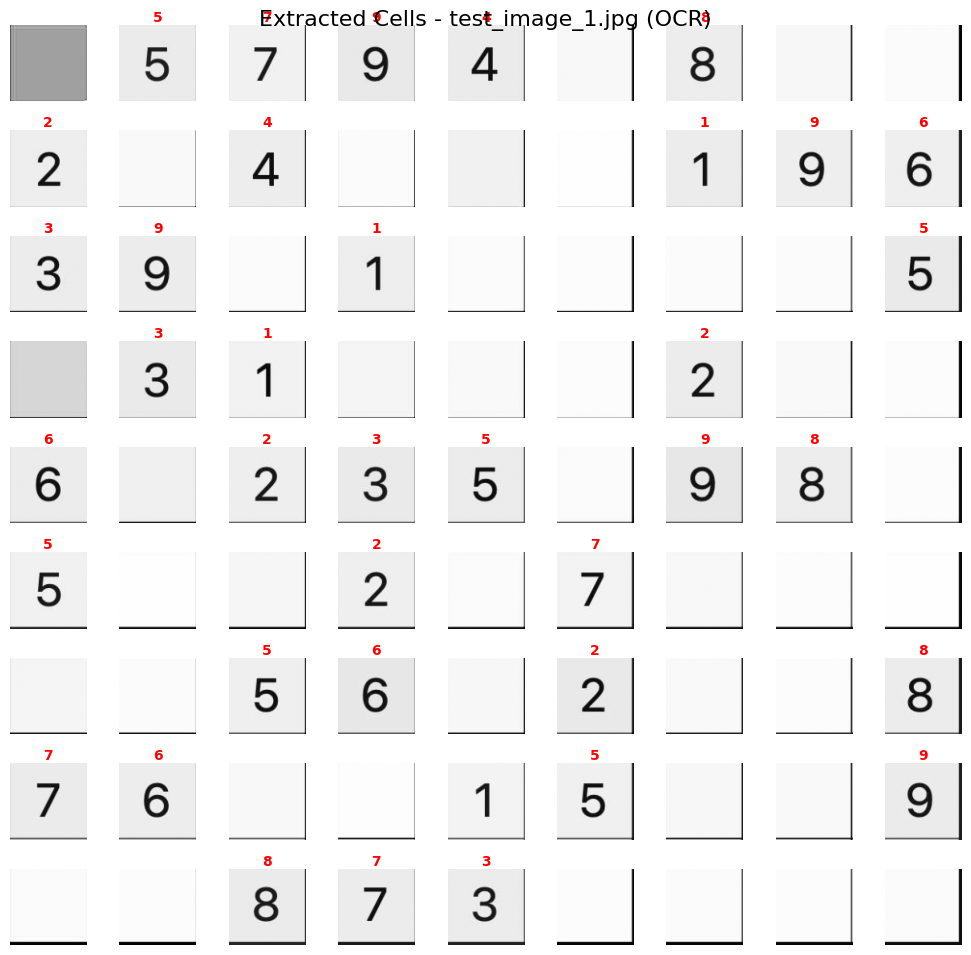

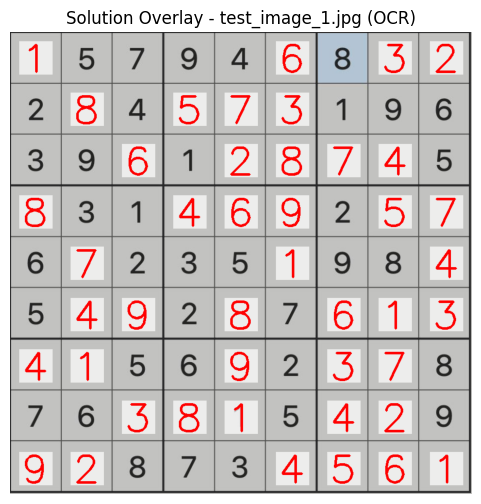


--- Processing test_image_2.jpg with OCR ---

=== test_image_2.jpg ===
Method: OCR
Warp method: contour-based
Detected board:
[[0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 8 0]
 [2 0 0 0 0 0 4 0 0]
 [0 7 0 0 0 0 0 0 0]
 [0 0 4 0 2 0 0 0 0]
 [0 0 0 0 0 8 0 0 0]
 [0 4 0 3 0 0 0 0 0]
 [0 0 7 0 0 0 3 0 0]
 [0 5 0 0 0 0 0 0 0]]
Metrics:
  • Cell Accuracy (all 81 cells)      : 86.42%
  • Avg. Prediction Confidence        : 0.94
  • Solver produced full valid board? : Yes
  • Time taken (ms)                   : 6778


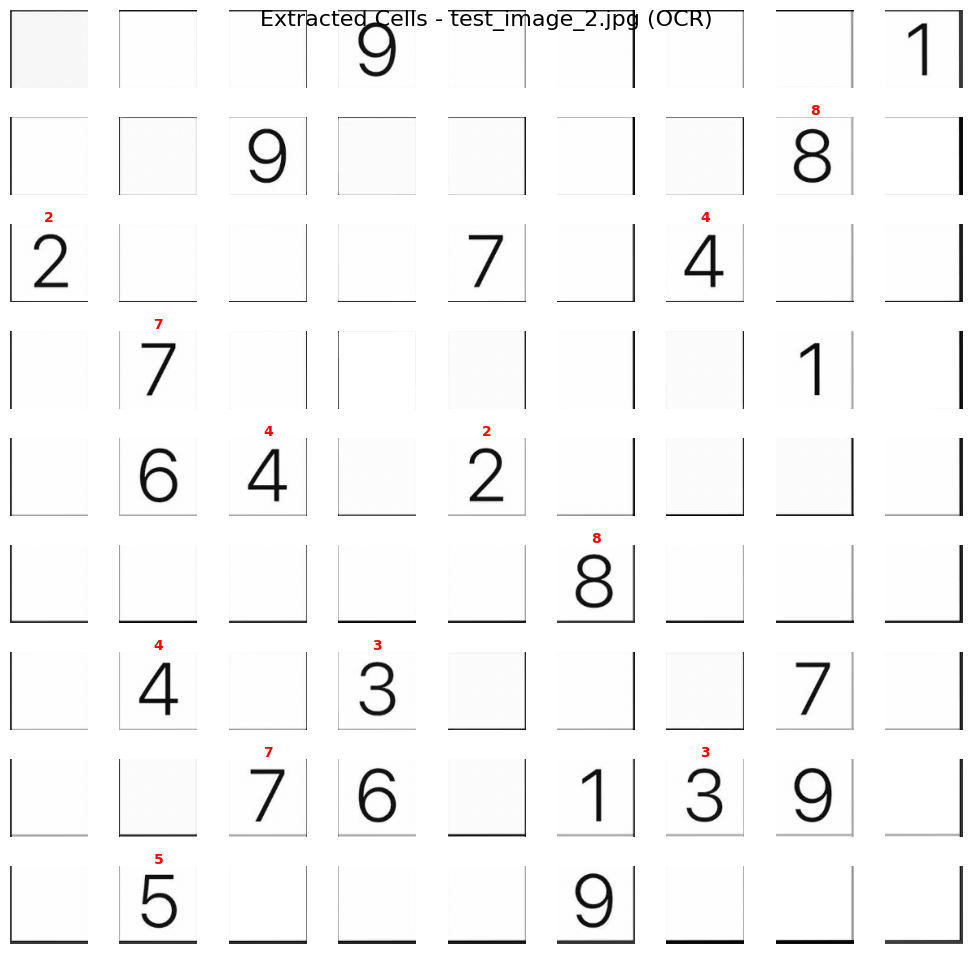

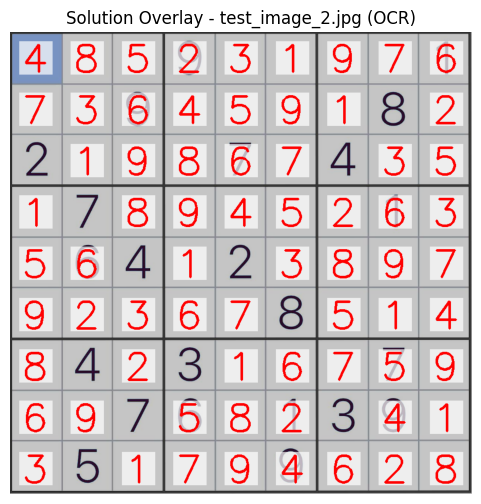


--- Processing test_image_3.jpg with OCR ---

=== test_image_3.jpg ===
Method: OCR
Warp method: contour-based
Detected board:
[[0 0 8 0 0 0 0 0 0]
 [0 4 0 7 0 0 0 0 0]
 [3 0 0 0 0 0 0 0 2]
 [0 0 0 0 2 0 5 0 7]
 [0 0 0 0 0 0 2 0 0]
 [0 0 0 5 3 0 0 0 0]
 [4 0 3 0 0 0 0 0 5]
 [0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 8 4]]
Metrics:
  • Cell Accuracy (all 81 cells)      : 88.89%
  • Avg. Prediction Confidence        : 0.89
  • Solver produced full valid board? : Yes
  • Time taken (ms)                   : 7409


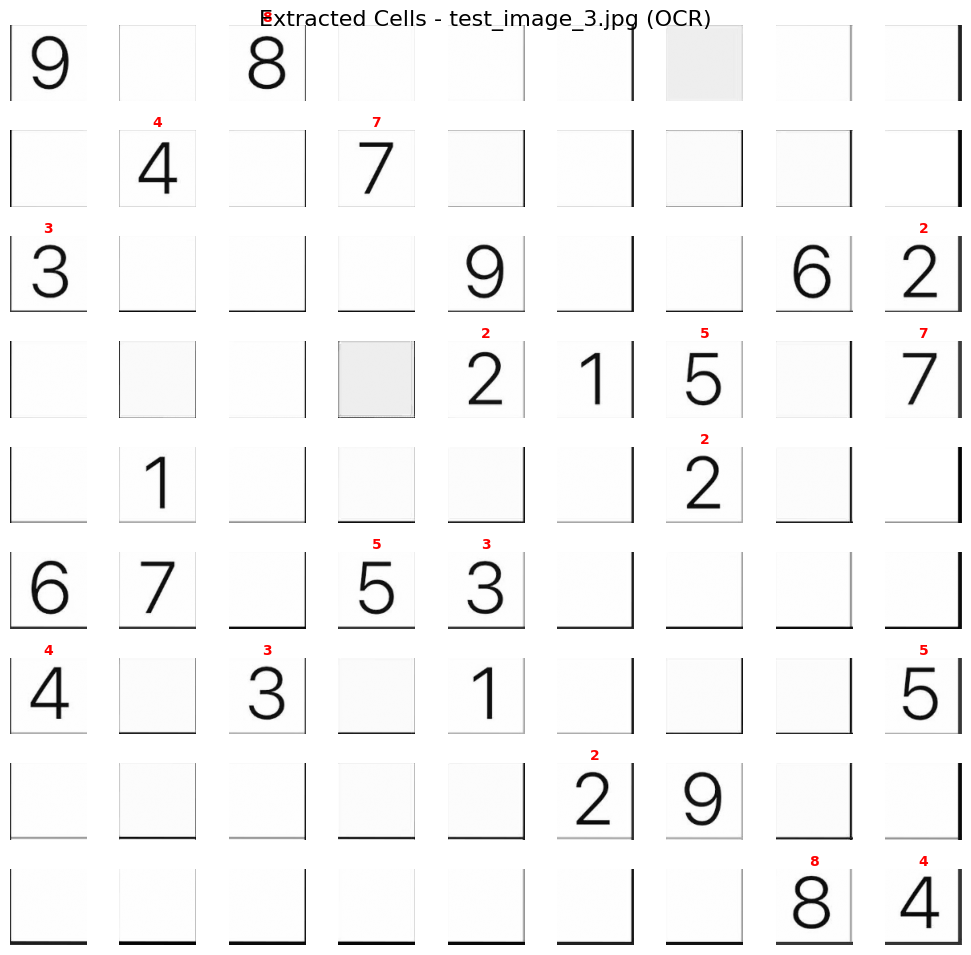

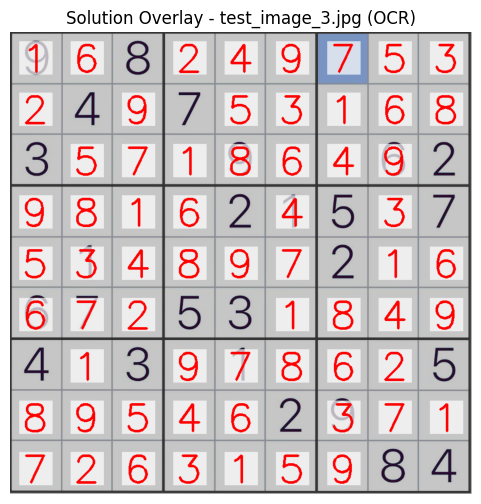


--- Processing test_image_4.jpg with OCR ---

=== test_image_4.jpg ===
Method: OCR
Warp method: contour-based
Detected board:
[[4 0 0 0 0 0 0 3 8]
 [7 3 2 8 0 4 0 0 0]
 [0 0 5 3 0 6 2 4 0]
 [0 7 0 0 2 0 5 0 0]
 [5 2 0 4 0 0 0 0 3]
 [0 0 0 0 5 3 8 0 0]
 [0 0 7 0 0 0 3 0 0]
 [0 8 0 0 0 0 4 2 0]
 [2 0 0 0 0 5 0 0 0]]
Metrics:
  • Cell Accuracy (all 81 cells)      : 75.31%
  • Avg. Prediction Confidence        : 0.95
  • Solver produced full valid board? : Yes
  • Time taken (ms)                   : 8811


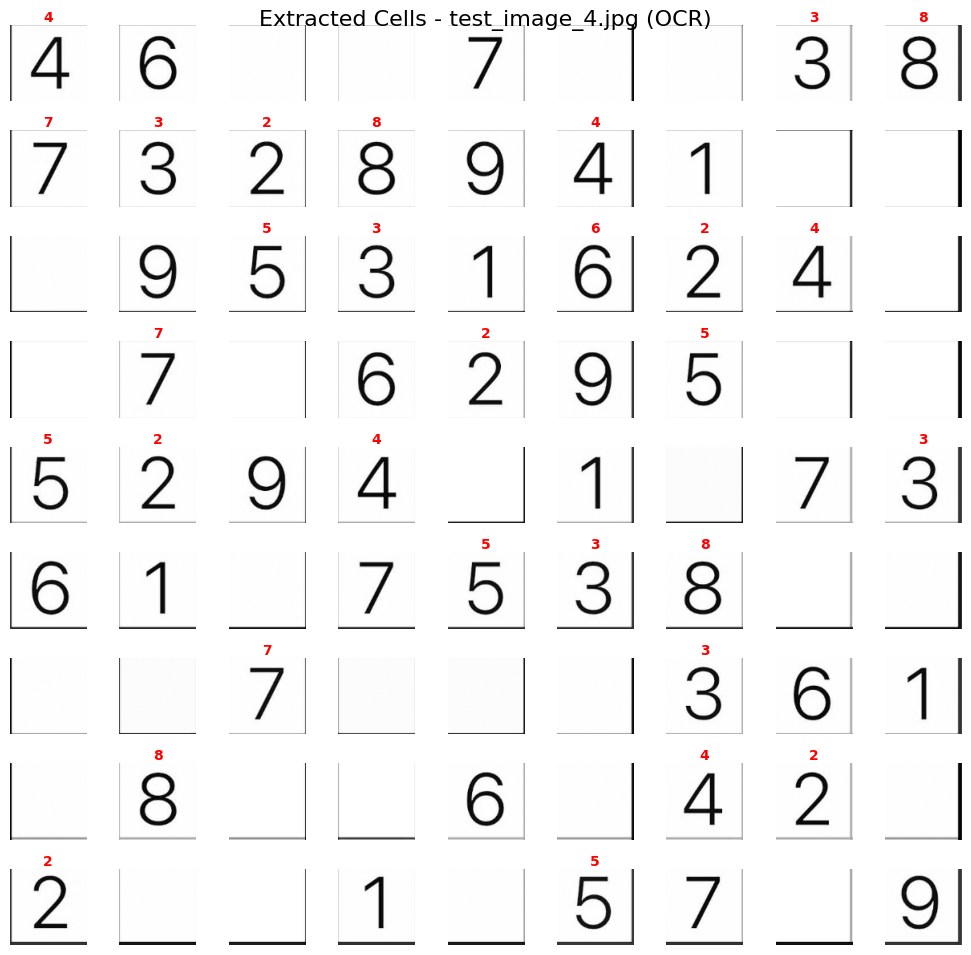

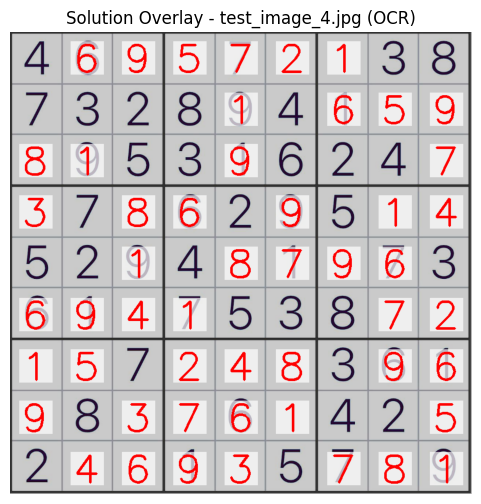


--- Processing test_image_5.jpg with OCR ---

=== test_image_5.jpg ===
Method: OCR
Warp method: contour-based
Detected board:
[[8 0 0 0 0 0 0 5 3]
 [3 0 7 0 2 0 0 6 0]
 [0 0 0 0 0 5 0 0 0]
 [0 0 0 2 0 0 0 7 8]
 [0 0 4 5 0 8 3 0 0]
 [1 0 0 0 0 0 0 2 5]
 [0 0 0 0 5 0 0 0 2]
 [0 0 0 0 8 0 0 3 0]
 [0 0 0 0 0 0 0 4 0]]
Metrics:
  • Cell Accuracy (all 81 cells)      : 82.72%
  • Avg. Prediction Confidence        : 0.96
  • Solver produced full valid board? : Yes
  • Time taken (ms)                   : 8622


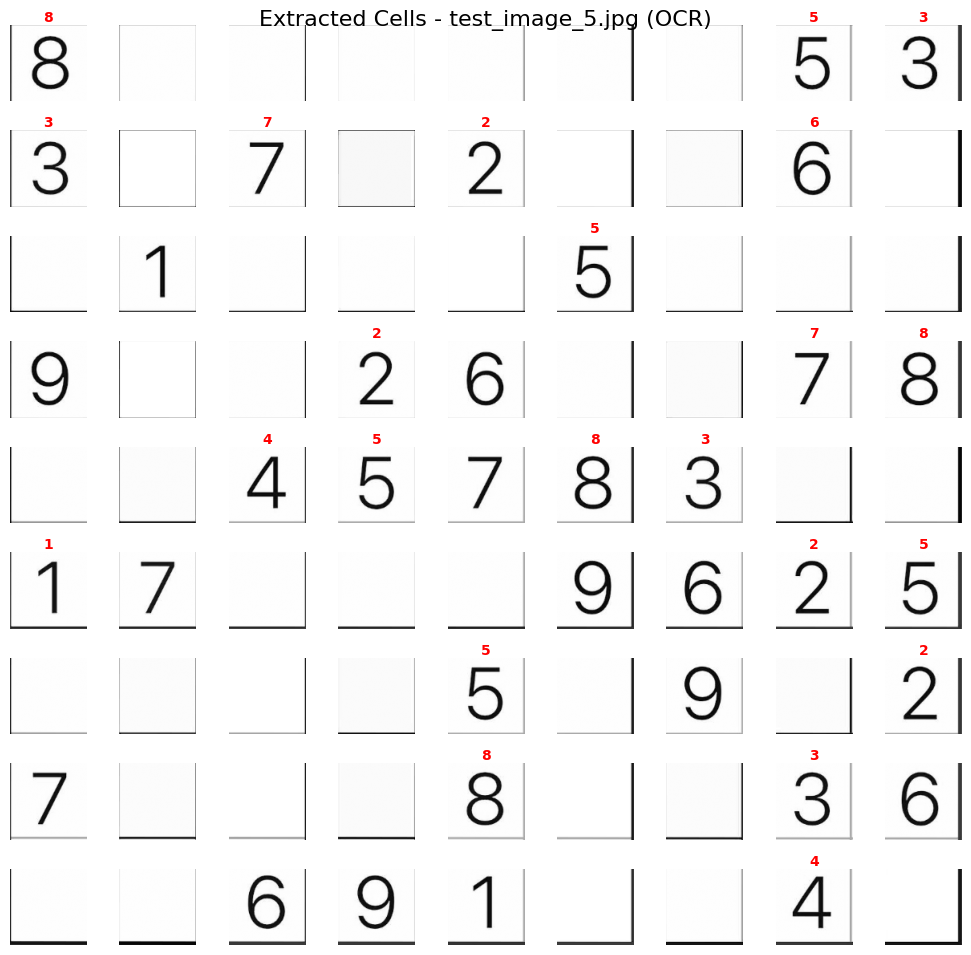

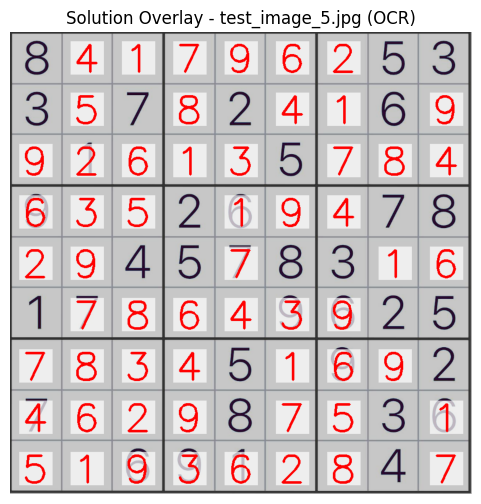


OCR METHOD SUMMARY
           Filename Accuracy Avg Confidence Solver Valid Time (ms)
0  test_image_1.jpg   98.77%           0.95          Yes      8842
1  test_image_2.jpg   86.42%           0.94          Yes      6778
2  test_image_3.jpg   88.89%           0.89          Yes      7409
3  test_image_4.jpg   75.31%           0.95          Yes      8811
4  test_image_5.jpg   82.72%           0.96          Yes      8622

OCR Averages:
  • Average Accuracy: 86.42%
  • Average Confidence: 0.94
  • Solver Success Rate: 5/5
  • Average Time: 8092 ms

PROCESSING ALL IMAGES WITH CNN METHOD

--- Processing test_image_1.jpg with CNN ---

=== test_image_1.jpg ===
Method: CNN
Warp method: contour-based
Detected board:
[[0 5 7 9 4 0 8 0 0]
 [2 0 4 0 0 0 1 9 6]
 [3 9 0 1 0 0 0 0 5]
 [0 3 1 0 0 0 2 0 0]
 [6 0 2 3 5 0 9 8 0]
 [5 0 0 2 0 7 0 0 0]
 [0 0 5 6 0 2 0 0 8]
 [7 6 0 0 1 5 0 0 9]
 [0 0 8 7 3 0 0 0 0]]
Metrics:
  • Cell Accuracy (all 81 cells)      : 100.00%
  • Avg. Prediction Confidence       

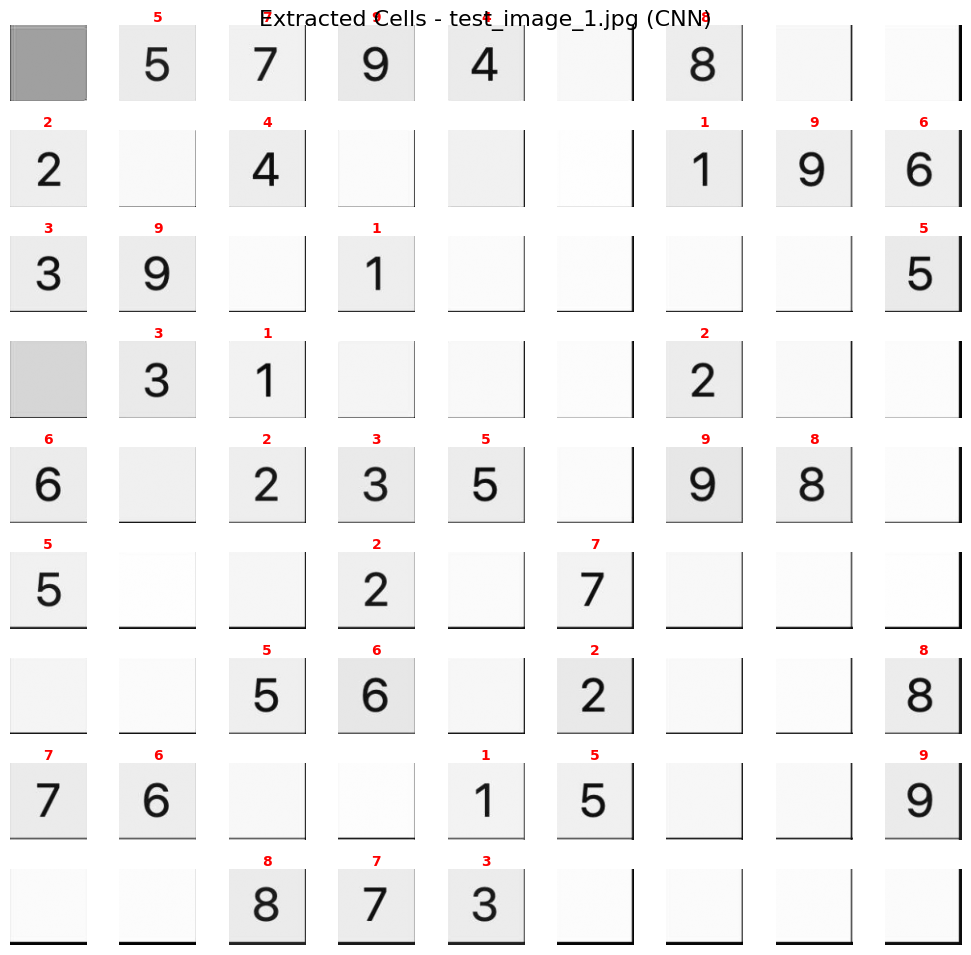

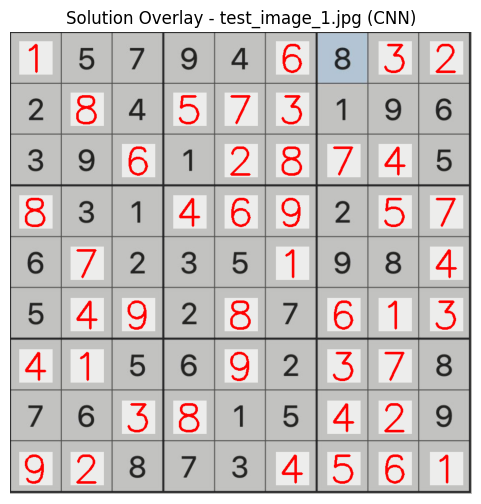


--- Processing test_image_2.jpg with CNN ---

=== test_image_2.jpg ===
Method: CNN
Warp method: contour-based
Detected board:
[[0 0 0 9 0 0 0 0 1]
 [0 0 9 0 0 0 0 8 0]
 [2 0 0 0 7 0 4 0 0]
 [0 7 0 0 0 0 0 1 0]
 [0 6 4 0 2 0 0 0 0]
 [0 0 0 0 0 8 0 0 0]
 [0 4 0 3 0 0 0 7 0]
 [0 0 7 6 0 1 3 9 0]
 [0 5 0 0 0 9 0 0 0]]
Metrics:
  • Cell Accuracy (all 81 cells)      : 100.00%
  • Avg. Prediction Confidence        : 0.99
  • Solver produced full valid board? : Yes
  • Time taken (ms)                   : 2495


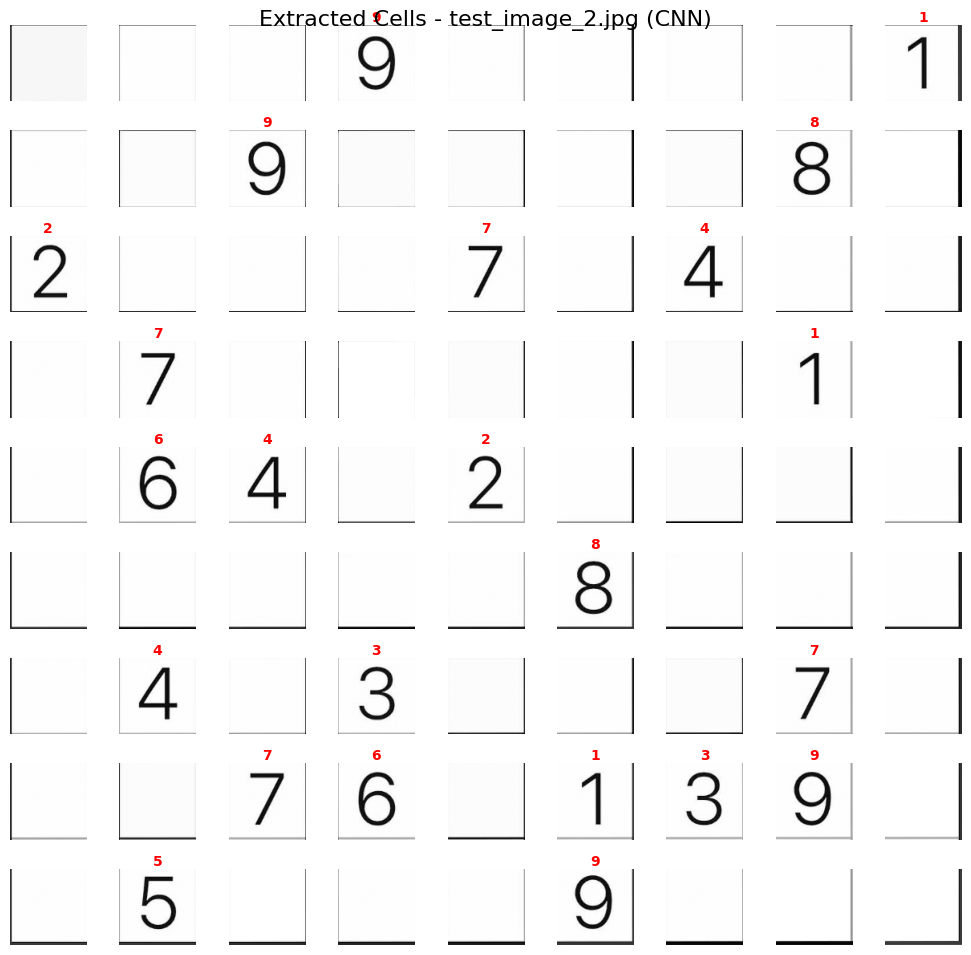

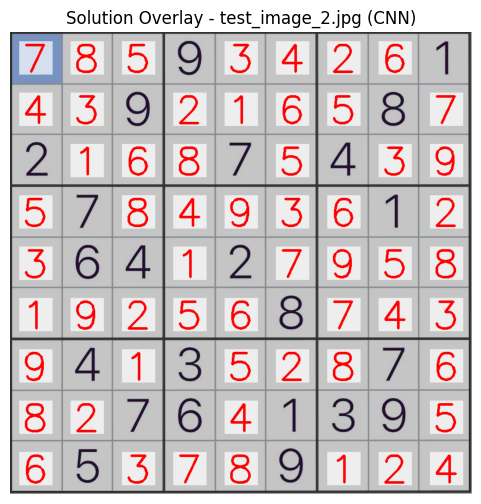


--- Processing test_image_3.jpg with CNN ---

=== test_image_3.jpg ===
Method: CNN
Warp method: contour-based
Detected board:
[[9 0 8 0 0 0 0 0 0]
 [0 4 0 7 0 0 0 0 0]
 [3 0 0 0 9 0 0 6 2]
 [0 0 0 0 2 1 5 0 7]
 [0 1 0 0 0 0 2 0 0]
 [6 7 0 5 3 0 0 0 0]
 [4 0 3 0 1 0 0 0 5]
 [0 0 0 0 0 2 9 0 0]
 [0 0 0 0 0 0 0 8 4]]
Metrics:
  • Cell Accuracy (all 81 cells)      : 100.00%
  • Avg. Prediction Confidence        : 0.99
  • Solver produced full valid board? : Yes
  • Time taken (ms)                   : 2962


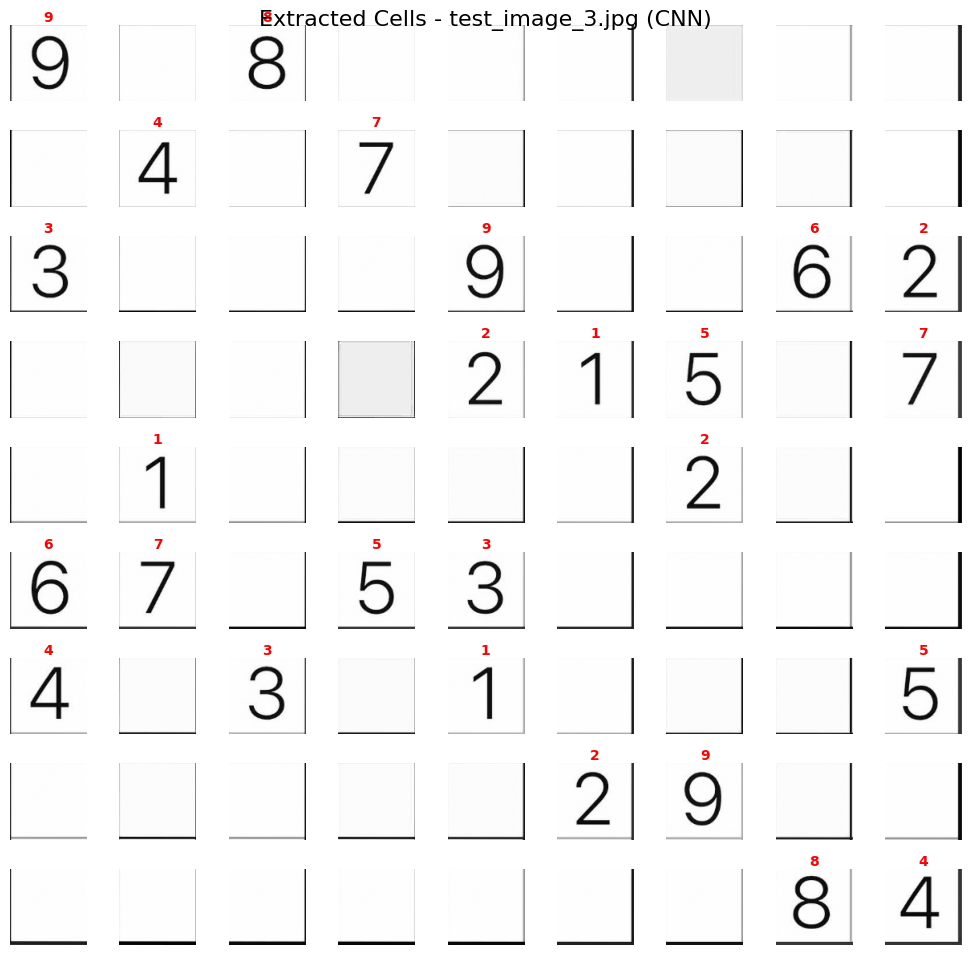

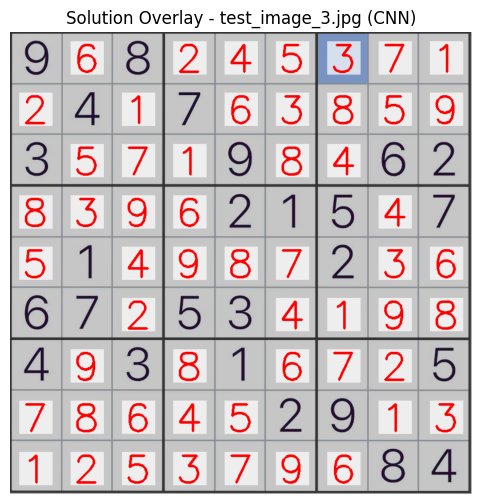


--- Processing test_image_4.jpg with CNN ---

=== test_image_4.jpg ===
Method: CNN
Warp method: contour-based
Detected board:
[[4 6 0 0 7 0 0 3 8]
 [7 3 2 8 9 0 1 0 0]
 [0 9 5 3 1 6 2 4 0]
 [0 7 0 6 2 9 5 0 0]
 [5 2 9 4 0 1 0 7 3]
 [6 1 0 7 5 3 8 0 0]
 [0 0 7 0 0 0 3 6 1]
 [0 8 0 0 6 0 4 2 0]
 [2 0 0 1 0 5 7 0 9]]
Metrics:
  • Cell Accuracy (all 81 cells)      : 98.77%
  • Avg. Prediction Confidence        : 0.99
  • Solver produced full valid board? : Yes
  • Time taken (ms)                   : 4224


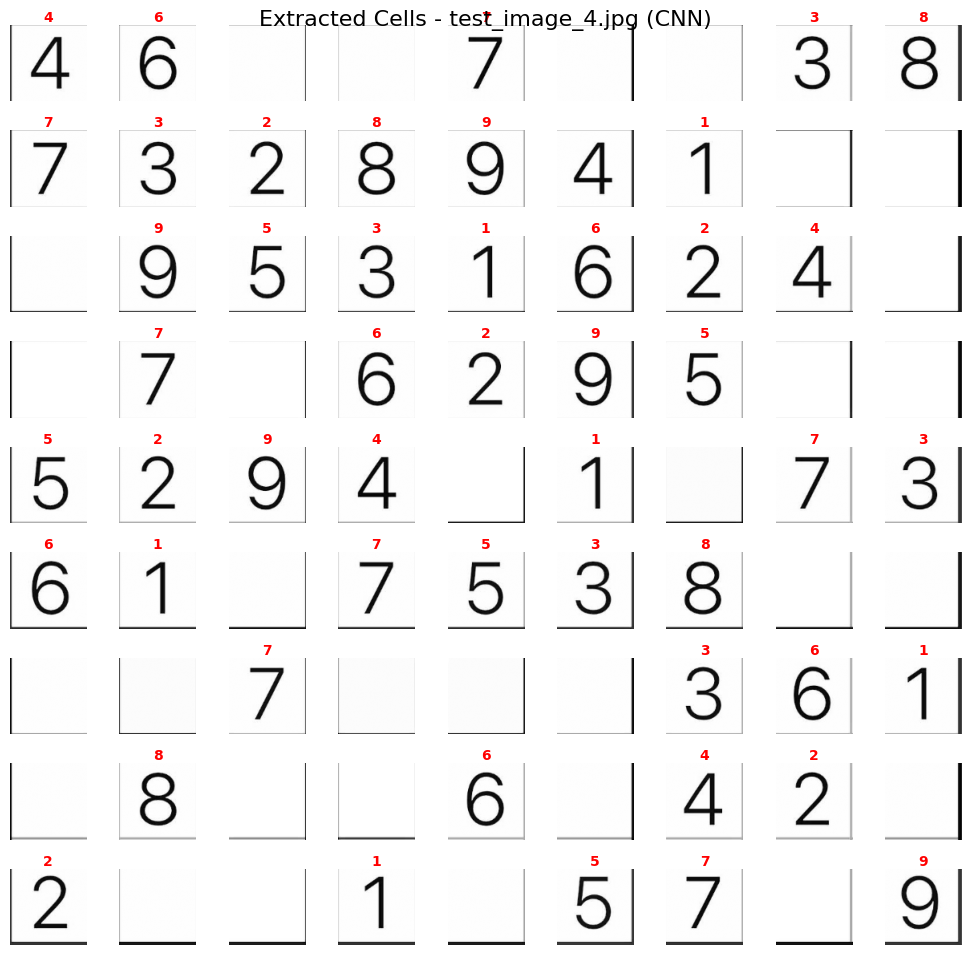

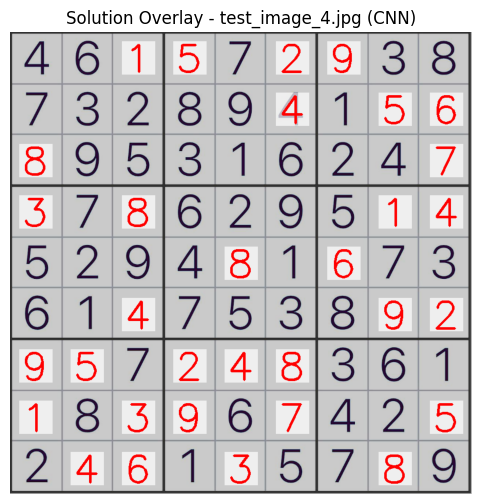


--- Processing test_image_5.jpg with CNN ---

=== test_image_5.jpg ===
Method: CNN
Warp method: contour-based
Detected board:
[[8 0 0 0 0 0 0 5 3]
 [3 0 7 0 2 0 0 6 0]
 [0 1 0 0 0 5 0 0 0]
 [9 0 0 2 6 0 0 7 8]
 [0 0 4 5 7 8 3 0 0]
 [1 7 0 0 0 9 6 2 5]
 [0 0 0 0 5 0 9 0 2]
 [7 0 0 0 8 0 0 3 6]
 [0 0 6 9 1 0 0 4 0]]
Metrics:
  • Cell Accuracy (all 81 cells)      : 96.30%
  • Avg. Prediction Confidence        : 0.99
  • Solver produced full valid board? : Yes
  • Time taken (ms)                   : 3184


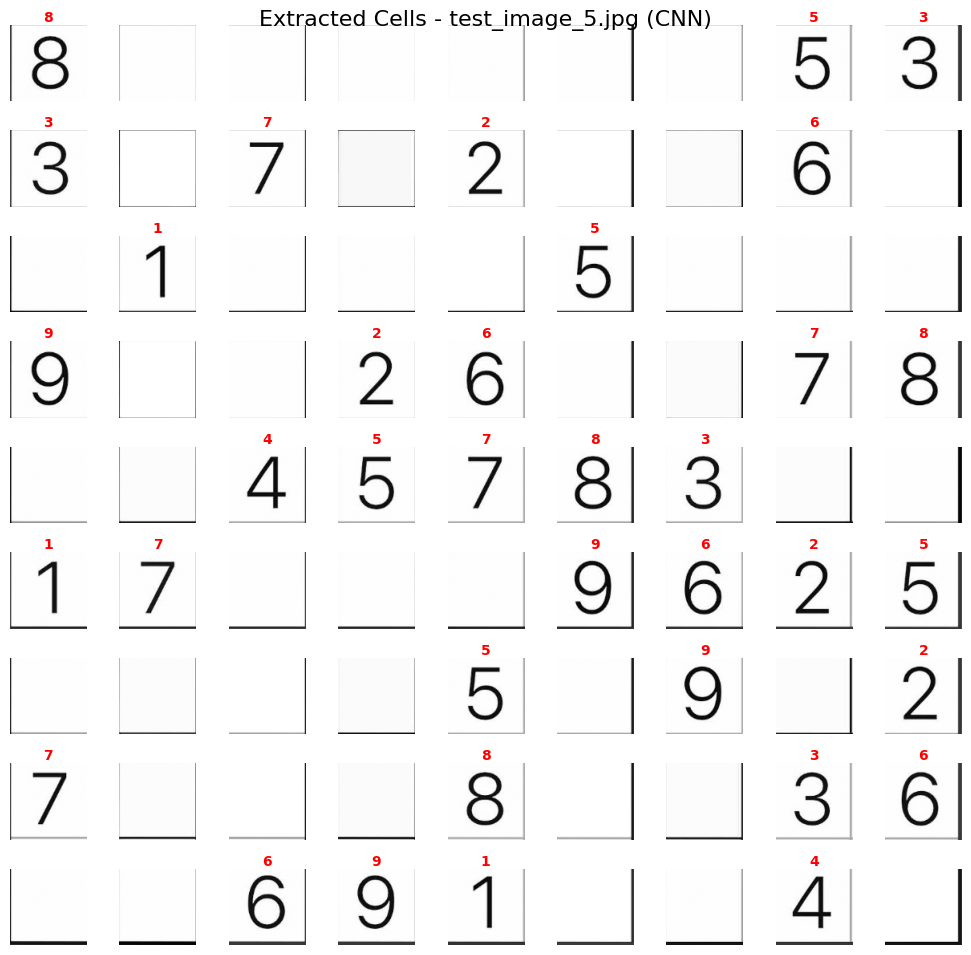

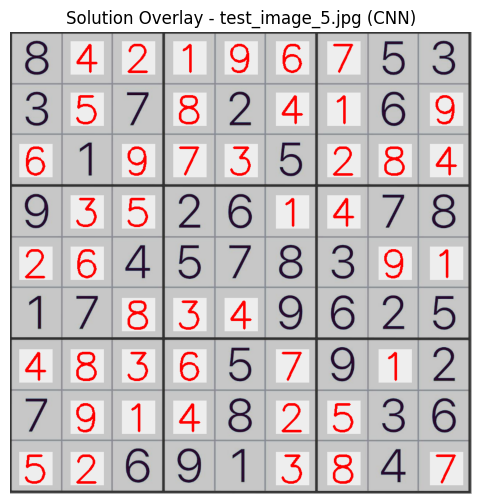


CNN METHOD SUMMARY
           Filename Accuracy Avg Confidence Solver Valid Time (ms)
0  test_image_1.jpg  100.00%           1.00          Yes      3430
1  test_image_2.jpg  100.00%           0.99          Yes      2495
2  test_image_3.jpg  100.00%           0.99          Yes      2962
3  test_image_4.jpg   98.77%           0.99          Yes      4224
4  test_image_5.jpg   96.30%           0.99          Yes      3184

CNN Averages:
  • Average Accuracy: 99.01%
  • Average Confidence: 0.99
  • Solver Success Rate: 5/5
  • Average Time: 3259 ms

PROCESSING ALL IMAGES WITH HYBRID METHOD

--- Processing test_image_1.jpg with HYBRID ---

=== test_image_1.jpg ===
Method: HYBRID
Warp method: contour-based
Detected board:
[[0 5 7 9 4 0 8 0 0]
 [2 0 4 0 0 0 1 9 6]
 [3 9 0 1 0 0 0 0 5]
 [0 3 1 0 0 0 2 0 0]
 [6 0 2 3 5 0 9 8 0]
 [5 0 0 2 0 7 0 0 0]
 [0 0 5 6 0 2 0 0 8]
 [7 6 0 0 1 5 0 0 9]
 [0 0 8 7 3 0 0 0 0]]
Metrics:
  • Cell Accuracy (all 81 cells)      : 100.00%
  • Avg. Prediction Confiden

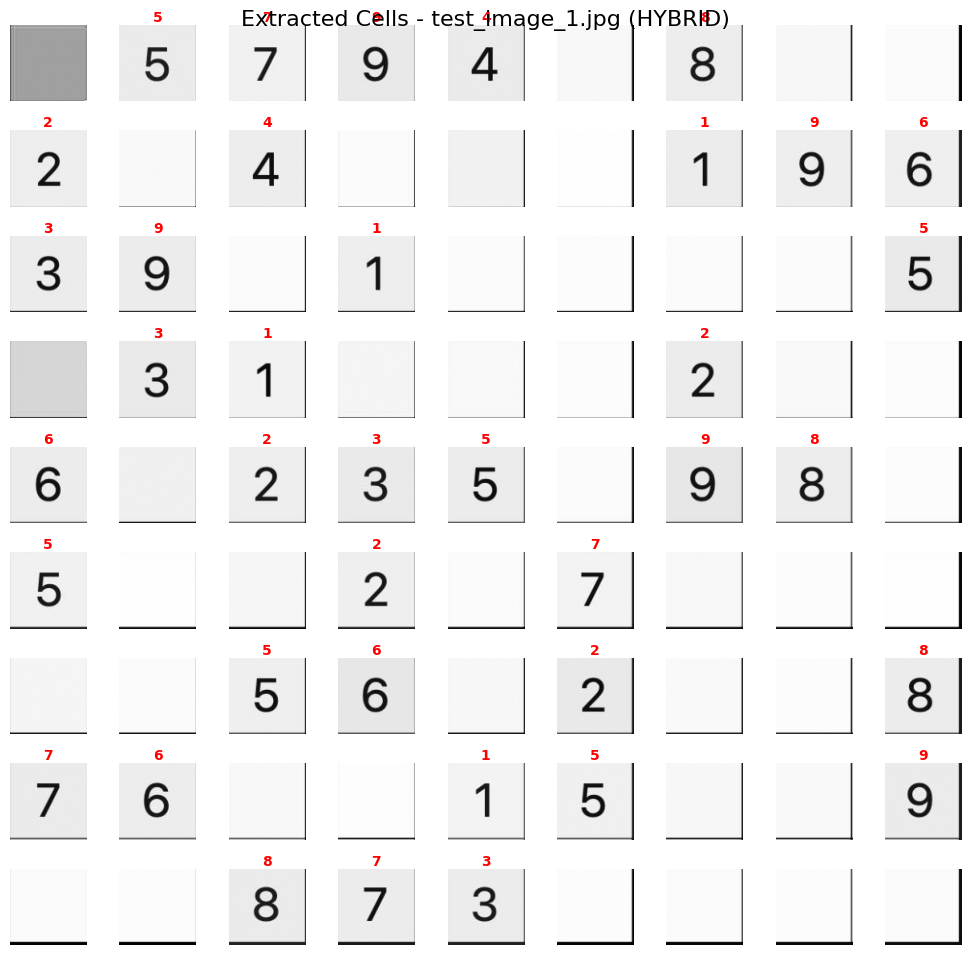

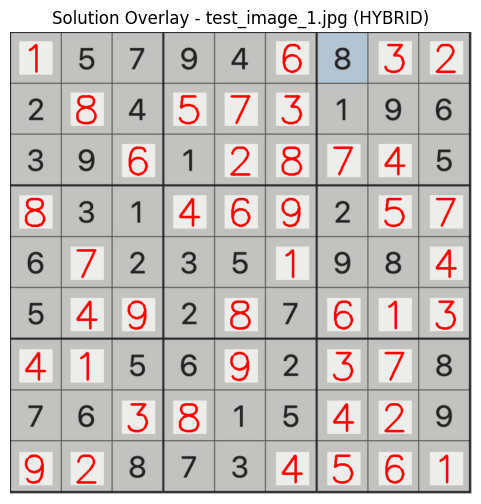


--- Processing test_image_2.jpg with HYBRID ---

=== test_image_2.jpg ===
Method: HYBRID
Warp method: contour-based
Detected board:
[[0 0 0 9 0 0 0 0 1]
 [0 0 9 0 0 0 0 8 0]
 [2 0 0 0 7 0 4 0 0]
 [0 7 0 0 0 0 0 1 0]
 [0 6 4 0 2 0 0 0 0]
 [0 0 0 0 0 8 0 0 0]
 [0 4 0 3 0 0 0 7 0]
 [0 0 7 6 0 1 3 9 0]
 [0 5 0 0 0 9 0 0 0]]
Metrics:
  • Cell Accuracy (all 81 cells)      : 100.00%
  • Avg. Prediction Confidence        : 0.99
  • Solver produced full valid board? : Yes
  • Time taken (ms)                   : 2048


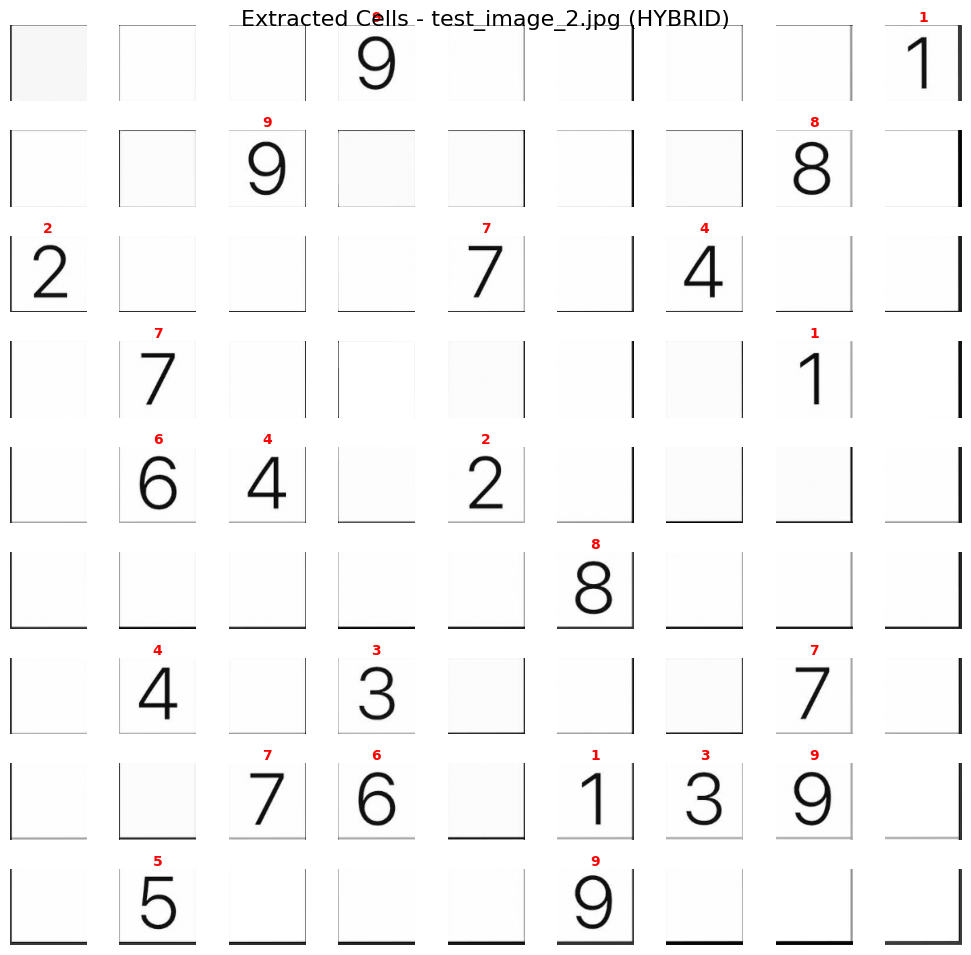

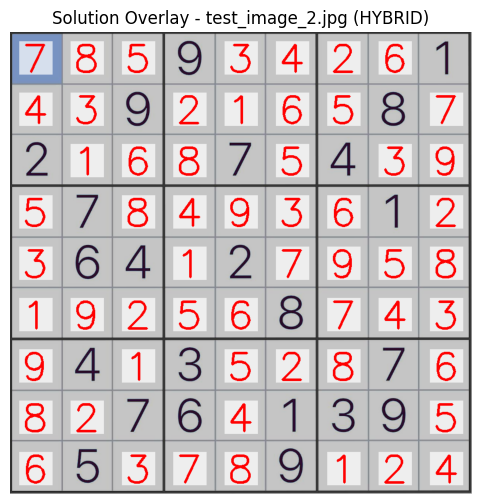


--- Processing test_image_3.jpg with HYBRID ---

=== test_image_3.jpg ===
Method: HYBRID
Warp method: contour-based
Detected board:
[[9 0 8 0 0 0 0 0 0]
 [0 4 0 7 0 0 0 0 0]
 [3 0 0 0 9 0 0 6 2]
 [0 0 0 0 2 1 5 0 7]
 [0 1 0 0 0 0 2 0 0]
 [6 7 0 5 3 0 0 0 0]
 [4 0 3 0 1 0 0 0 5]
 [0 0 0 0 0 2 9 0 0]
 [0 0 0 0 0 0 0 8 4]]
Metrics:
  • Cell Accuracy (all 81 cells)      : 100.00%
  • Avg. Prediction Confidence        : 0.99
  • Solver produced full valid board? : Yes
  • Time taken (ms)                   : 2356


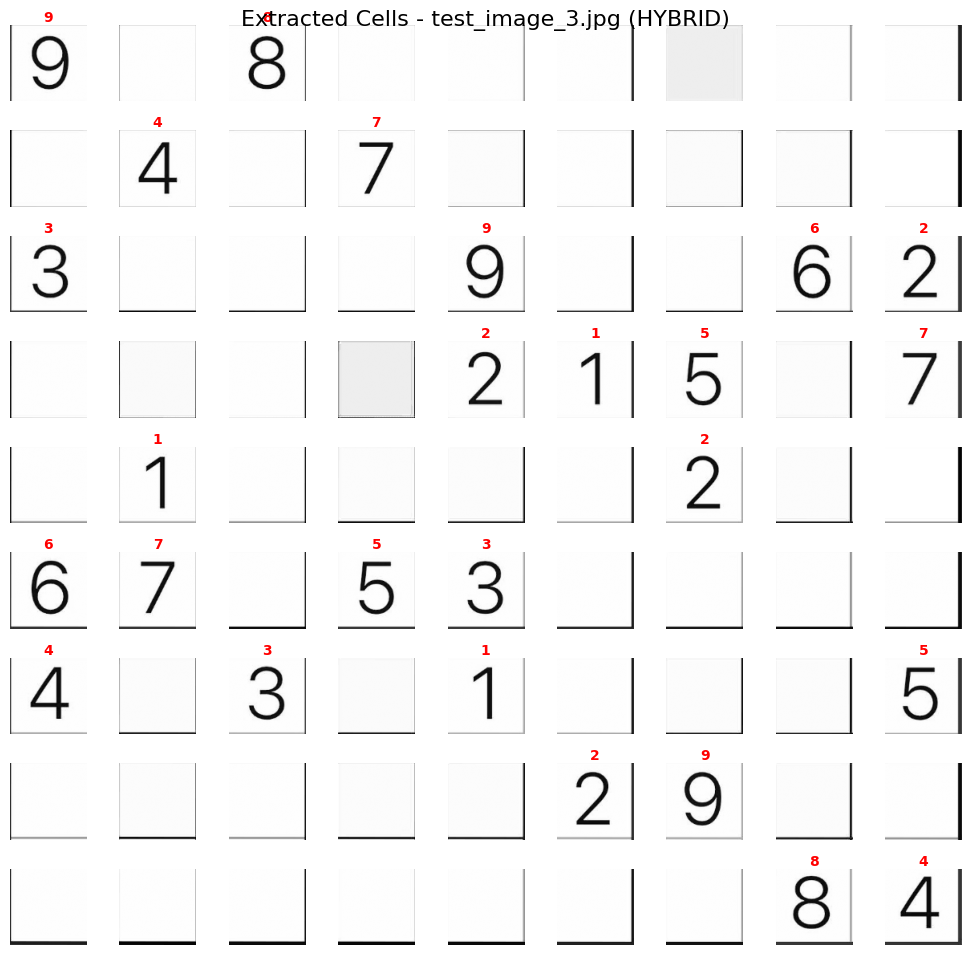

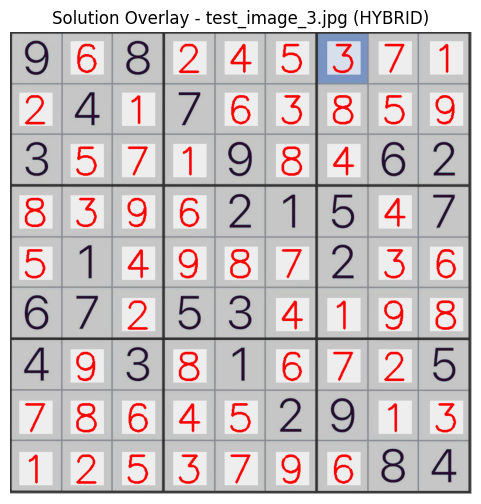


--- Processing test_image_4.jpg with HYBRID ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



=== test_image_4.jpg ===
Method: HYBRID
Warp method: contour-based
Detected board:
[[4 6 0 0 7 0 0 3 8]
 [7 3 2 8 9 0 1 0 0]
 [0 9 5 3 1 6 2 4 0]
 [0 7 0 6 2 9 5 0 0]
 [5 2 9 4 0 1 0 7 3]
 [6 1 0 7 5 3 8 0 0]
 [0 0 7 0 0 0 3 6 1]
 [0 8 0 0 6 0 4 2 0]
 [2 0 0 1 0 5 7 0 9]]
Metrics:
  • Cell Accuracy (all 81 cells)      : 98.77%
  • Avg. Prediction Confidence        : 0.99
  • Solver produced full valid board? : Yes
  • Time taken (ms)                   : 5736


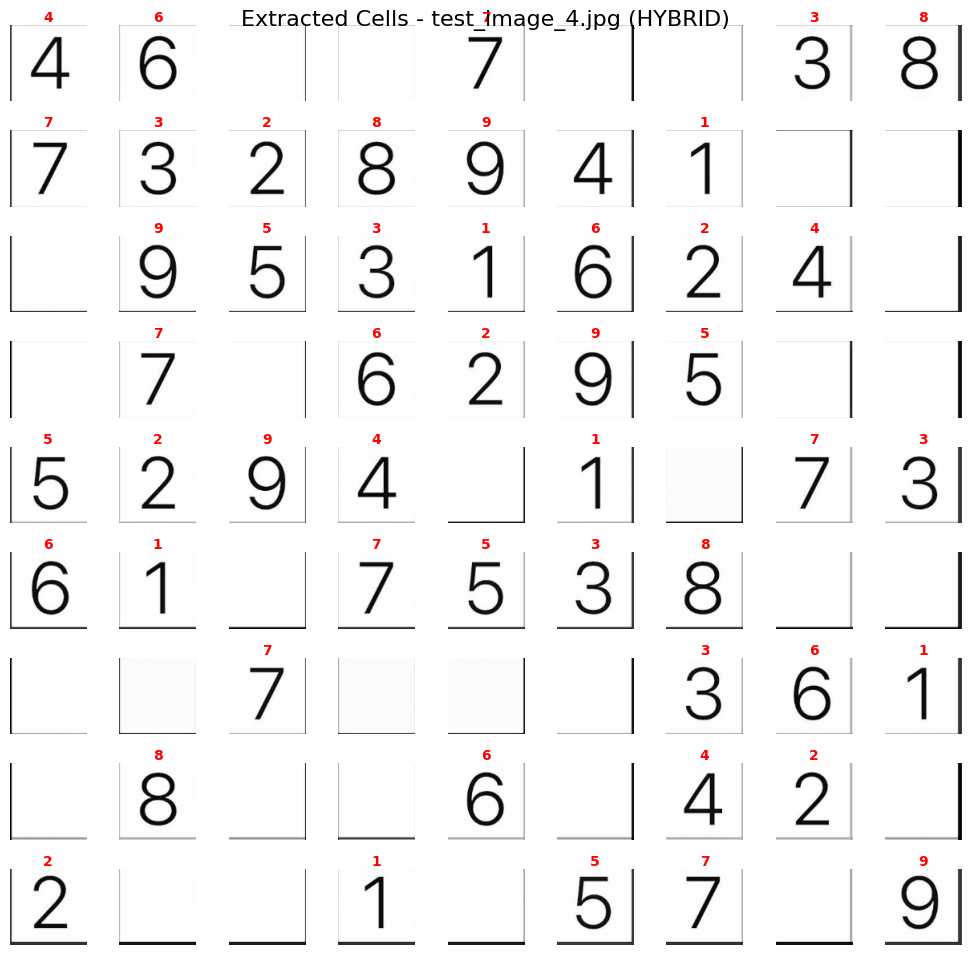

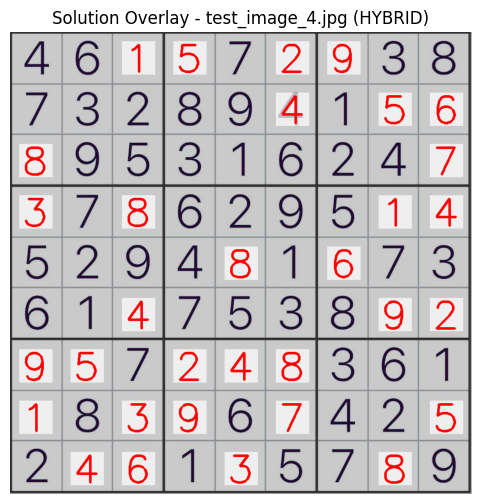


--- Processing test_image_5.jpg with HYBRID ---

=== test_image_5.jpg ===
Method: HYBRID
Warp method: contour-based
Detected board:
[[8 0 0 0 0 0 0 5 3]
 [3 0 7 0 2 0 0 6 0]
 [0 1 0 0 0 5 0 0 0]
 [9 0 0 2 6 0 0 7 8]
 [0 0 4 5 7 8 3 0 0]
 [1 7 0 0 0 9 6 2 5]
 [0 0 0 0 5 0 9 0 2]
 [7 0 0 0 8 0 0 3 6]
 [0 0 6 9 1 0 0 4 0]]
Metrics:
  • Cell Accuracy (all 81 cells)      : 96.30%
  • Avg. Prediction Confidence        : 0.99
  • Solver produced full valid board? : Yes
  • Time taken (ms)                   : 3221


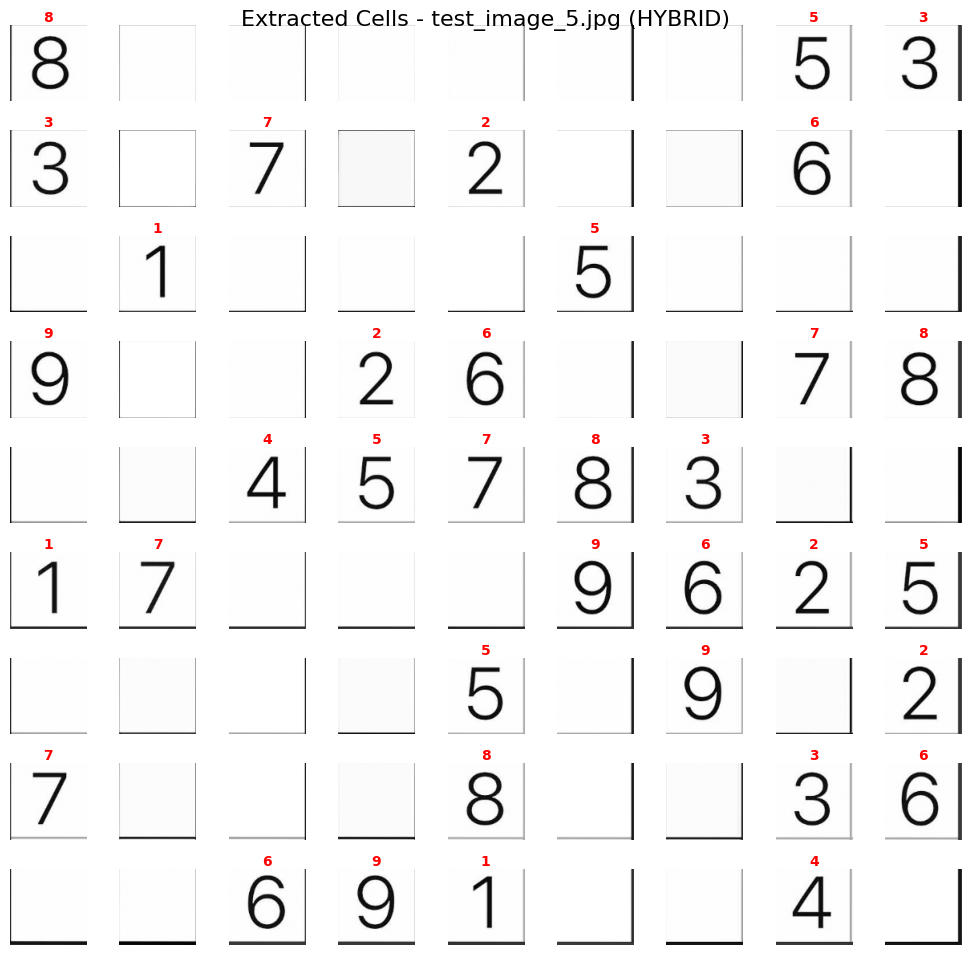

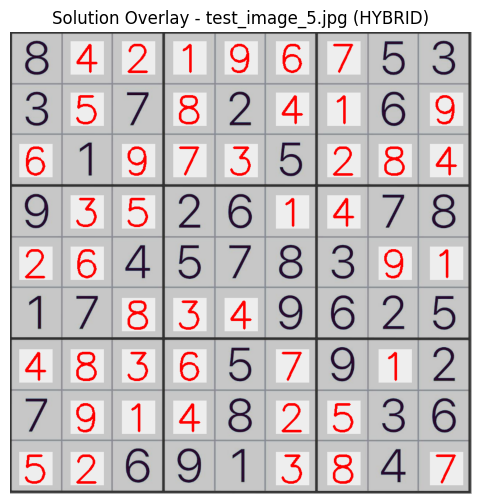


HYBRID METHOD SUMMARY
           Filename Accuracy Avg Confidence Solver Valid Time (ms)
0  test_image_1.jpg  100.00%           1.00          Yes      4489
1  test_image_2.jpg  100.00%           0.99          Yes      2048
2  test_image_3.jpg  100.00%           0.99          Yes      2356
3  test_image_4.jpg   98.77%           0.99          Yes      5736
4  test_image_5.jpg   96.30%           0.99          Yes      3221

HYBRID Averages:
  • Average Accuracy: 99.01%
  • Average Confidence: 0.99
  • Solver Success Rate: 5/5
  • Average Time: 3570 ms

FINAL COMPREHENSIVE SUMMARY

=== Overall Performance Comparison ===
   Method Avg Accuracy Avg Confidence Solver Success Rate Avg Time (ms)
0     OCR       86.42%           0.94                 5/5          8092
1     CNN       99.01%           0.99                 5/5          3259
2  HYBRID       99.01%           0.99                 5/5          3570


In [27]:
# 7. MAIN EXECUTION BLOCK
# =============================================================================

def main():
    """Main function to run all three solutions on multiple images"""
    print("=== COMPLETE SUDOKU SOLVER: OCR + CNN + HYBRID ===\n")

    # Setup CNN model
    cnn_model = setup_cnn_model()

    # Define ground truth for your test images (you'll need to fill these in)
    GROUND_TRUTH = {
        "test_image_1.jpg": np.array([
            [0,5,7,9,4,0,8,0,0],
            [2,0,4,0,0,0,1,9,6],
            [3,9,0,1,0,0,0,0,5],
            [0,3,1,0,0,0,2,0,0],
            [6,0,2,3,5,0,9,8,0],
            [5,0,0,2,0,7,0,0,0],
            [0,0,5,6,0,2,0,0,8],
            [7,6,0,0,1,5,0,0,9],
            [0,0,8,7,3,0,0,0,0]
        ], dtype=int),

        "test_image_2.jpg": np.array([
            [0,0,0,9,0,0,0,0,1],
            [0,0,9,0,0,0,0,8,0],
            [2,0,0,0,7,0,4,0,0],
            [0,7,0,0,0,0,0,1,0],
            [0,6,4,0,2,0,0,0,0],
            [0,0,0,0,0,8,0,0,0],
            [0,4,0,3,0,0,0,7,0],
            [0,0,7,6,0,1,3,9,0],
            [0,5,0,0,0,9,0,0,0]
        ], dtype=int),

        "test_image_3.jpg": np.array([
            [9,0,8,0,0,0,0,0,0],
            [0,4,0,7,0,0,0,0,0],
            [3,0,0,0,9,0,0,6,2],
            [0,0,0,0,2,1,5,0,7],
            [0,1,0,0,0,0,2,0,0],
            [6,7,0,5,3,0,0,0,0],
            [4,0,3,0,1,0,0,0,5],
            [0,0,0,0,0,2,9,0,0],
            [0,0,0,0,0,0,0,8,4]
        ], dtype=int),

        "test_image_4.jpg": np.array([
            [4,6,0,0,7,0,0,3,8],
            [7,3,2,8,9,4,1,0,0],
            [0,9,5,3,1,6,2,4,0],
            [0,7,0,6,2,9,5,0,0],
            [5,2,9,4,0,1,0,7,3],
            [6,1,0,7,5,3,8,0,0],
            [0,0,7,0,0,0,3,6,1],
            [0,8,0,0,6,0,4,2,0],
            [2,0,0,1,0,5,7,0,9]
        ], dtype=int),

        "test_image_5.jpg": np.array([
            [8,0,0,0,0,0,0,5,3],
            [3,0,7,0,2,0,0,6,0],
            [0,1,0,0,0,5,0,0,0],
            [9,0,2,6,0,0,0,7,8],
            [0,0,4,5,7,8,3,0,0],
            [1,7,0,0,0,9,6,2,5],
            [0,0,0,0,5,0,9,0,2],
            [7,0,0,0,8,0,0,3,6],
            [0,0,6,9,1,0,0,4,0]
        ], dtype=int)
    }

    import glob
    for file in glob.glob("/content/test_image_*.jpg"):
        try:
            os.remove(file)
            print(f"Removed existing file: {file}")
        except:
            pass

    # Upload images
    print("\nUpload Sudoku images (test_image_1.jpg to test_image_5.jpg):")
    uploaded = files.upload()
    if not uploaded:
        print("No files uploaded!")
        return

    # Fix filenames - remove any (1), (2) suffixes that Colab added
    canonical_names = []
    for raw_name, raw_bytes in uploaded.items():
        # Remove any (1), (2), etc. suffixes that Colab adds
        canonical = re.sub(r" \(\d+\)(?=\.jpg$)", "", raw_name)
        dest = os.path.join("/content", canonical)

        # Remove existing file if it exists
        if os.path.exists(dest):
            os.remove(dest)

        # Write with canonical name
        with open(dest, "wb") as f:
            f.write(raw_bytes)

        canonical_names.append(canonical)
        print(f"Saved as: {canonical}")

    all_results = []

    # Process by METHOD first (not by image)
    for method in ["ocr", "cnn", "hybrid"]:
        print(f"\n{'='*80}")
        print(f"PROCESSING ALL IMAGES WITH {method.upper()} METHOD")
        print(f"{'='*80}")

        method_results = []

        for filename in sorted(canonical_names):  # Use canonical names
            print(f"\n--- Processing {filename} with {method.upper()} ---")
            image_path = f"/content/{filename}"
            ground_truth = GROUND_TRUTH.get(filename)

            try:
                result = process_single_image(image_path, method, cnn_model, ground_truth)
                if result:
                    # Ensure filename in result uses canonical name
                    result['filename'] = filename
                    method_results.append(result)
                    all_results.append(result)

                    # Display metrics for this image
                    display_metrics([result])

                    # Show extracted cells for this image
                    visualize_extracted_cells(result['cells'], result['board'], f"{filename} ({method.upper()})")

                    # Show overlay if solved successfully
                    if result['overlay_img'] is not None:
                        plt.figure(figsize=(6, 6))
                        plt.imshow(cv2.cvtColor(result['overlay_img'], cv2.COLOR_BGR2RGB))
                        plt.title(f"Solution Overlay - {filename} ({method.upper()})")
                        plt.axis('off')
                        plt.show()
                    else:
                        print(f"  No solution overlay available for {filename}")

            except Exception as e:
                print(f"Error processing {filename} with {method}: {e}")
                import traceback
                traceback.print_exc()

        # Display method summary after processing all images with this method
        if method_results:
            print(f"\n{'='*60}")
            print(f"{method.upper()} METHOD SUMMARY")
            print(f"{'='*60}")

            method_df = pd.DataFrame([{
                'Filename': r['filename'],
                'Accuracy': f"{r['accuracy']:.2f}%" if r['accuracy'] is not None else "N/A",
                'Avg Confidence': f"{r['avg_confidence']:.2f}",
                'Solver Valid': 'Yes' if r['solver_valid'] else 'No',
                'Time (ms)': f"{r['time_ms']:.0f}"
            } for r in method_results])
            print(method_df)

            # Calculate averages for this method
            accuracies = [r['accuracy'] for r in method_results if r['accuracy'] is not None]
            confidences = [r['avg_confidence'] for r in method_results]
            times = [r['time_ms'] for r in method_results]
            solver_success = sum(1 for r in method_results if r['solver_valid'])

            if accuracies:
                print(f"\n{method.upper()} Averages:")
                print(f"  • Average Accuracy: {np.mean(accuracies):.2f}%")
                print(f"  • Average Confidence: {np.mean(confidences):.2f}")
                print(f"  • Solver Success Rate: {solver_success}/{len(method_results)}")
                print(f"  • Average Time: {np.mean(times):.0f} ms")

    # Final comprehensive summary
    print(f"\n{'='*80}")
    print("FINAL COMPREHENSIVE SUMMARY")
    print(f"{'='*80}")

    summary_df = create_summary_table(all_results)
    print("\n=== Overall Performance Comparison ===")
    print(summary_df)

# Run the main function
if __name__ == "__main__":
    main()
